# 1. Import the required libraries

In [1]:
# Standard code libraries
import os
import matplotlib.pyplot as plt
import numpy as np

# Custom code libraries from ReSurfEMG
from resurfemg.data_connector.config import Config
from resurfemg.data_connector import file_discovery
from resurfemg.preprocessing import ecg_removal
from resurfemg.postprocessing import features as feat
from resurfemg.postprocessing import quality_assessment as qa
from resurfemg.pipelines import ipy_widgets
from resurfemg.data_connector.tmsisdk_lite import Poly5Reader
from resurfemg.data_connector.data_classes import (
VentilatorDataGroup, EmgDataGroup)

%matplotlib widget

## 2. Load the ventilator and sEMG data

In [2]:
# Identify all recordings available for the selected patient/measurement_date

# First find the patients
config = Config()

# Then find the files for the selected patients:
base_path = config.get_directory('pilsen_data')
folder_levels = None

emg_files = file_discovery.find_files(
    base_path=base_path,
    file_name_regex='*',
    extension_regex='adicht',
    folder_levels=None)


In [3]:
# If you want to select another file:
btn_list_emg = ipy_widgets.file_select(
    emg_files,
    folder_levels=['files'],
    default_value_select=None,
    default_idx_select=[0])
# btn_list_vent = ipy_widgets.file_select(
#     vent_files,
#     folder_levels=['files'],
#     default_value_select=None,
#     default_idx_select=[0])

interactive(children=(Dropdown(description='files:', options=('Oligo54diaphragm.adicht', 'emg_exper 2.adicht',…

In [102]:
# Load the EMG and ventilator data recordings from the selected folders.
#emg_file_chosen = os.path.join(base_path, emg_files['files'].values[0])
#vent_file_chosen = os.path.join(base_path, vent_files['files'].values[0])
# Alternatively:
emg_file_chosen = os.path.join(base_path, *[btn.value for btn in btn_list_emg])
# vent_file_chosen = os.path.join(base_path, *[btn.value for btn in btn_list_vent])
import resurfemg.data_connector.converter_functions as cf
data_emg, metadata = cf.load_adicht(emg_file_chosen,1)

## -------------------------------------------------------------------------##
# the 0 in loading the adicht file is the record number, 0 for  first channel
## -------------------------------------------------------------------------##

Loading .adicht ...
Loaded .adicht, extracting data ...
Available channels and metadata:
+-----+------------+-----------+---------+--------------+--------------------+----------------+--------------+
| idx | Channel ID | Name      | Records |   Samples    | Sampling Rate (Hz) |  timestep (s)  |    Units     |
+-----+------------+-----------+---------+--------------+--------------------+----------------+--------------+
|  0  |     1      | Channel 1 |    2    | 1290, 265261 |   2000.0, 2000.0   | 0.0005, 0.0005 | ['mV', 'mV'] |
|  1  |     2      | Channel 2 |    2    | 1290, 265261 |   2000.0, 2000.0   | 0.0005, 0.0005 | ['mV', 'mV'] |
+-----+------------+-----------+---------+--------------+--------------------+----------------+--------------+
Loading data completed


In [103]:
#data_emg_samples = data_emg
fs_emg = metadata['fs']

# Define the time series of the EMG
y_emg = data_emg

# Define the time axes
t_emg = [i/fs_emg for i in range(len(y_emg))]
#t_vent = [i/fs_vent for i in range(len(y_vent[0, :]))]

In [104]:
# Store the EMG data in a group of TimeSeries objects with both channels
emg_timeseries = EmgDataGroup(
    y_emg[['Channel 1', 'Channel 2']].to_numpy().T,
    fs=fs_emg,
    labels=['ECG', 'Channel 2'],
    units=['mV', 'mV']
)

#emg_timeseries.set_ecg_idx(2)

Auto-detected ECG channel from labels.


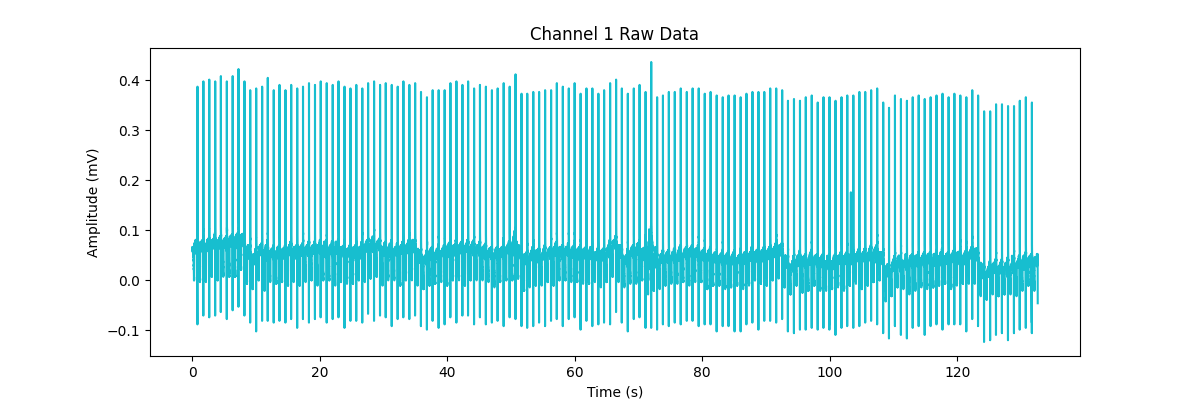

In [105]:
# Plot Channel 1 data from the timeseries
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(t_emg, y_emg['Channel 1'], color='tab:cyan')
ax.set_title('Channel 1 Raw Data')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude (mV)')
plt.show()

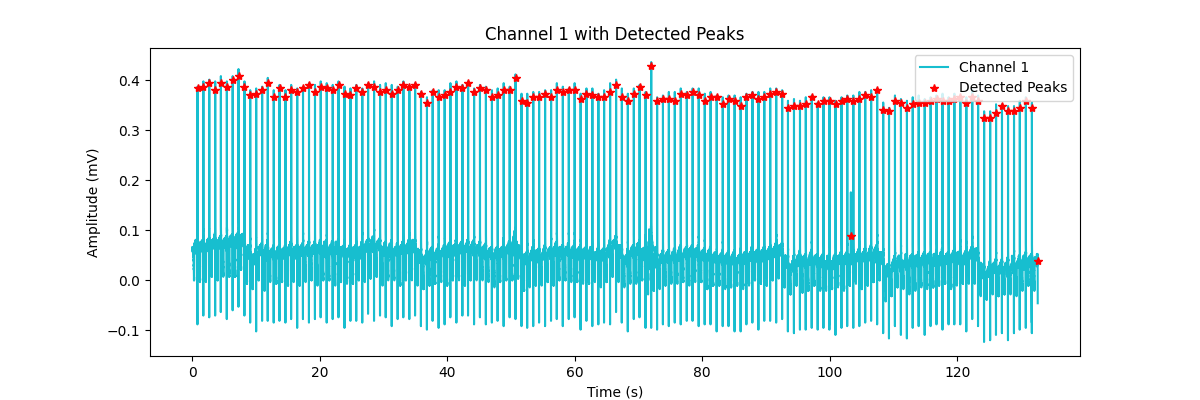

In [106]:
from resurfemg.preprocessing.ecg_removal import detect_ecg_peaks
# Detect peaks in Channel 1
signal = y_emg['Channel 1'].values
peaks = detect_ecg_peaks(signal, fs_emg)  # adjust distance as needed

# Store indices
ecg_idx = peaks

# Plot the signal and detected peaks
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(t_emg, signal, color='tab:cyan', label='Channel 1')
ax.plot(np.array(t_emg)[ecg_idx], signal[ecg_idx], 'r*', label='Detected Peaks')
ax.set_title('Channel 1 with Detected Peaks')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude (mV)')
ax.legend()
plt.show()

# 3. Pre-process the data

In [107]:
# Filter
emg_timeseries.run('filter_emg', hp_cf=100, lp_cf=400)


In [108]:
# # Through gating
emg_timeseries.run('gating',gate_width_samples=fs_emg//10)


# Through wavelet denoising
#emg_timeseries.wavelet_denoising(overwrite=True)
# emg_timeseries.wavelet_denoising(n=8, fixed_threshold=8.0, overwrite=True)

C:\Users\OppersmaE\eScience_projects\ReSurfEMG\resurfemg\data_connector\data_classes.py:1142: FutureWarning:  The kwargs 'ecg_peak_idxs', 'ecg_raw', 'bp_filter', 'overwrite' will
be removed from the gating and wavelet denoising methods in future
versions of ReSurfEMG: ECG removal will be split in QRS detection with
`get_ecg_peaks` and ECG elimination (`gating`/ `wavelet_denoising`):
TimeSeriesGroup.run('get_ecg_peaks', ...) Before running:
TimeSeriesGroup.run('gating', ...) or
TimeSeriesGroup.run('wavelet_denoising', ...)  Alternatively, create
an ECG peakset with `set_peaks` and use `gating` or
`wavelet_denoising` directly.
  warnings.warn("\n".join(wrap(dedent(


Set ECG channel used for ECG peak detection.


In [109]:
# Calculate the envelope of the signal
emg_timeseries.run('envelope', window_length=600, env_type='rms')
# emg_timeseries.envelope(env_type='arv')

In [110]:
# Calculate the baseline for the EMG envelopes and p_vent
emg_timeseries.run('baseline')
#vent_timeseries.baseline(
#    channel_idxs=[0],
#    signal_type='raw')

Text(0.5, 0, 't (s)')

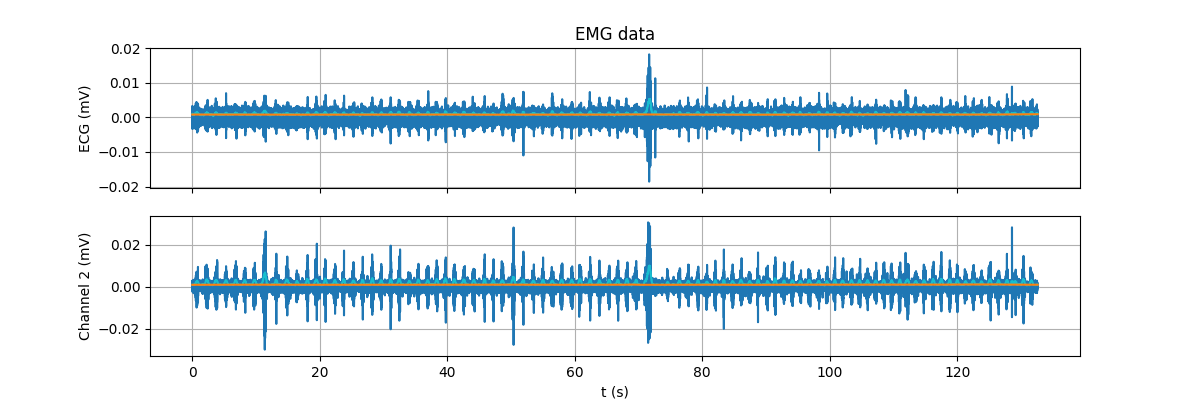

In [111]:
# Plot the raw data with the envelope
# EMG data
n_rows = max([len(emg_timeseries.channels)])
fig, axis = plt.subplots(nrows=n_rows, ncols=1, figsize=(12, n_rows*2), sharex=True)
#axes_emg = [axis[0]] if n_rows == 1 else axis[:, 0]
axes_emg = [axis] if n_rows == 1 else axis
colors = ['tab:cyan', 'tab:orange']
emg_timeseries.run(
    'plot_full', axes=axes_emg, signal_io=('clean',), baseline_bool=False)
emg_timeseries.run(
    'plot_full', axes=axes_emg, signal_io=('env',), colors=colors)

axes_emg[0].set_title('EMG data')
axes_emg[-1].set_xlabel('t (s)')


# 4. Identify all sEMG breaths, and find those closest to the Pocc peaks

In [75]:
# Find sEAdi peaks in one channel (sEAdi)
emg_di = emg_timeseries.channels[1]
emg_di.detect_emg_breaths(peak_set_name='breaths', overwrite=True)

emg_di.peaks['breaths'].detect_on_offset(
    baseline=emg_di.y_baseline
)

C:\Users\OppersmaE\eScience_projects\ReSurfEMG\resurfemg\data_connector\data_classes.py:92: FutureWarning:  The attribute y_baseline is deprecated to allow for more, and custom,
signal types. Use 'TimeSeries'[baseline] instead.
  warnings.warn("\n".join(wrap(dedent(


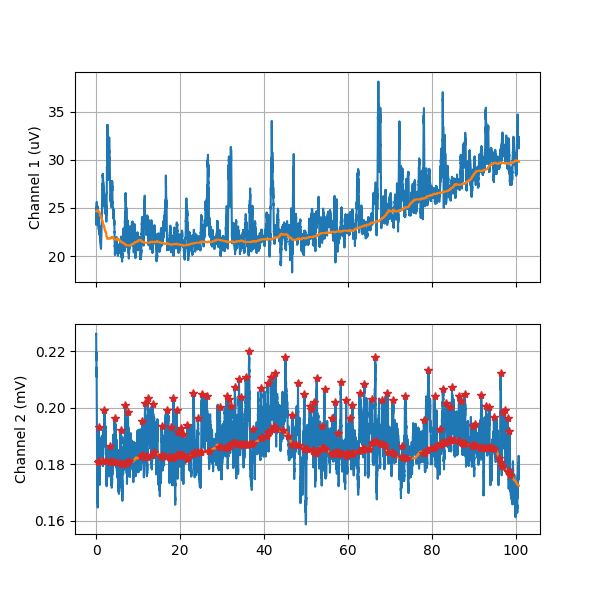

In [76]:
fig, axis = plt.subplots(nrows=n_rows, ncols=1, figsize=(n_rows*3, 6), sharex=True)
axes_emg = [axis] if n_rows == 1 else axis

colors = ['tab:cyan', 'tab:orange']
# emg_timeseries.run(
#     'plot_full', axes=axes_emg, signal_io=('clean',), baseline_bool=False)
emg_timeseries.run(
    'plot_full', axes=axes_emg, signal_io=('env',))
emg_timeseries[1].plot_markers(
    peak_set_name='breaths', axes=axes_emg[1], valid_only=False)

TypeError: list indices must be integers or slices, not Axes

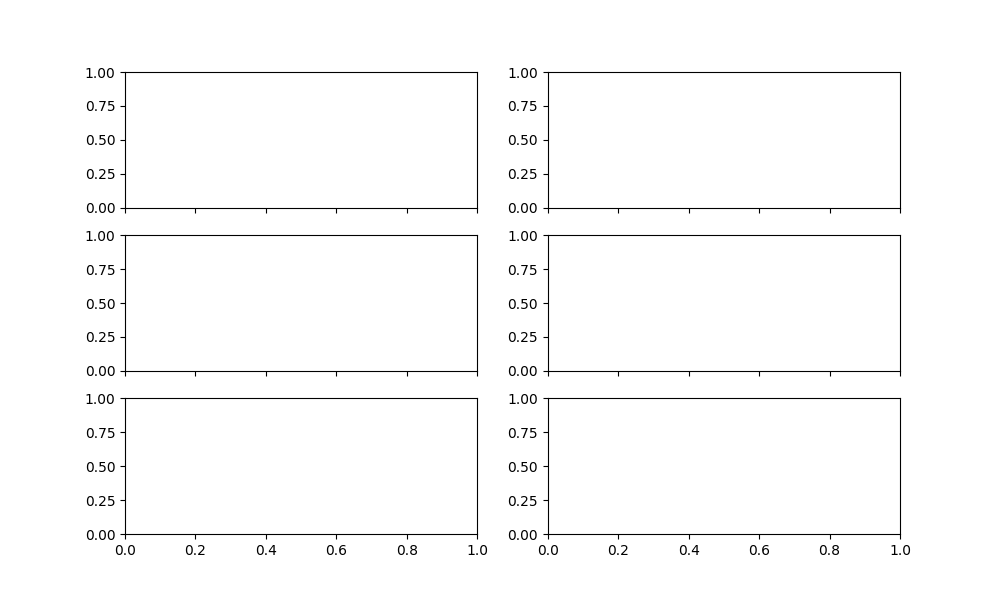

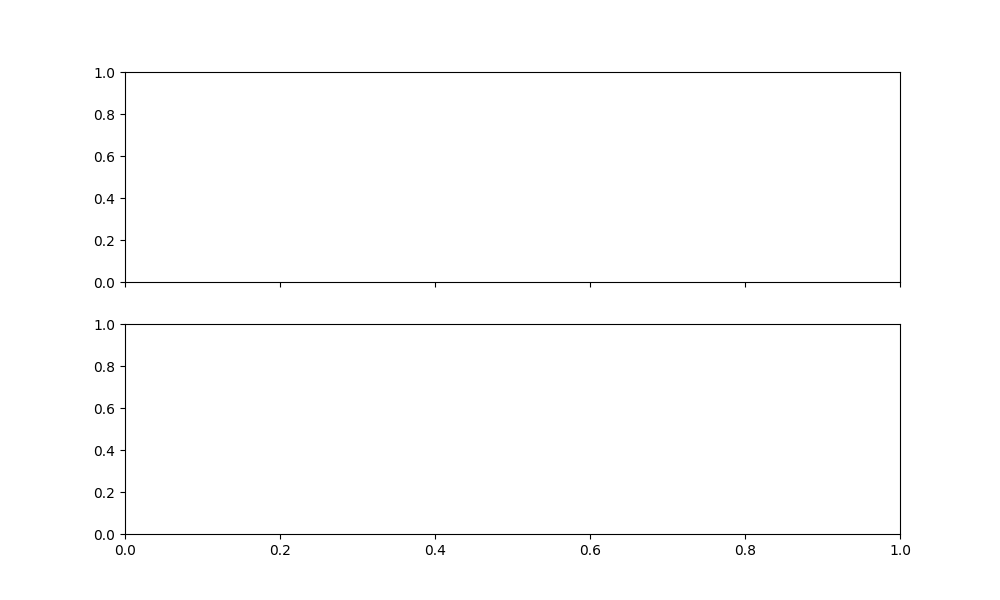

In [35]:
# Plot the identified Pocc peaks in p_vent and sEAdi
fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(10, 6), sharex=True)
axes_emg = axis[:-1, 0]
colors = ['tab:cyan', 'tab:orange', 'tab:red']
emg_timeseries.run('plot_full',axes_emg, signal_io=('env',))
emg_di.plot_markers(peak_set_name='breaths', axes=axes_emg[1])


axes_emg[1].set_ylabel('sEAdi (uV)')
axes_emg[0].set_title('EMG data')
axes_emg[-1].set_xlabel('t (s)')

# axes_vent = axis[:, 1]
# vent_timeseries.plot_full(axes_vent)
# p_vent.plot_markers(peak_set_name='Pocc', axes=axes_vent[0])
# v_vent.plot_markers(peak_set_name='ventilator_breaths',
#                     axes=axes_vent[2], colors='c')

# axes_vent[0].set_title('Ventilator data')
# axes_vent[-1].set_xlabel('t (s)')
# axes_vent[-1].set_xlim([370, 410])

axis[-1, 0].axis('off')

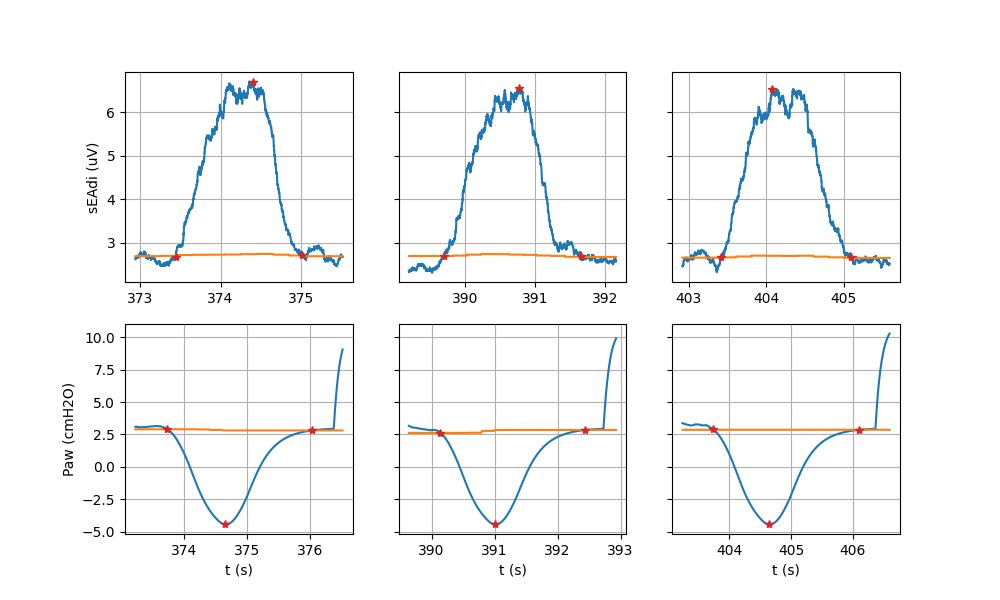

In [ ]:
# Plot the individual peaks
n_peaks = len(emg_di.peaks['Pocc'].peak_df['start_idx'].to_numpy())
fig, axis = plt.subplots(nrows=2, ncols=n_peaks, figsize=(10, 6), sharey='row')

axes_emg = axis[0, :]
colors = ['tab:cyan', 'tab:orange', 'tab:red']
emg_di.plot_peaks(axes=axes_emg, peak_set_name='Pocc')
emg_di.plot_markers(axes=axes_emg, peak_set_name='Pocc')
axes_emg[0].set_ylabel('sEAdi (uV)')

axes_vent = axis[1, :]
p_vent.plot_peaks(axes=axes_vent, peak_set_name='Pocc')
p_vent.plot_markers(axes=axes_vent, peak_set_name='Pocc')

for axis in axes_vent:
    axis.set_xlabel('t (s)')

# 5. Calculate features

In [21]:
# Respiratory rates
tv_idxs = v_vent.peaks['ventilator_breaths'].peak_df['peak_idx'].to_numpy()
rr_vent, _ = feat.respiratory_rate(
    tv_idxs, fs_vent
)

rr_vent, _ = feat.respiratory_rate(
    v_vent.peaks['ventilator_breaths'].peak_df['peak_idx'].to_numpy(),
    v_vent.param['fs'])
v_vent.param['rr'] = rr_vent
p_vent.param['rr'] = rr_vent
print('The detected respiratory rate in the ventilator data is: '
      + f'{round(rr_vent, 1)} /min')

emg_di_idxs = emg_di.peaks['breaths'].peak_df['peak_idx'].to_numpy()
rr_emg, _ = feat.respiratory_rate(
    emg_di_idxs, fs_emg
)
emg_di.param['rr'] = rr_emg
print('The detected respiratory rate in the sEAdi data is: '
      + f'{round(rr_emg, 1)} /min')

The detected respiratory rate in the ventilator data is: 22.0 /min
The detected respiratory rate in the sEAdi data is: 22.0 /min


In [22]:
# EMG amplitudes
emg_di_pocc_idxs = emg_di.peaks['Pocc'].peak_df['peak_idx'].to_numpy()
sEAdi_amplitudes = feat.amplitude(
    signal=emg_di.y_env,
    peak_idxs=emg_di_pocc_idxs,
    baseline=emg_di.y_baseline,
)
print('The sEAdi amplitudes are:')
print(sEAdi_amplitudes)

The sEAdi amplitudes are:
[3.97351188 3.84477595 3.84752319]


In [ ]:
# Calculate PTPocc
p_vent.calculate_time_products(
    peak_set_name='Pocc',
    aub_reference_signal=p_vent.y_baseline,
    parameter_name='PTPocc')
print(p_vent.peaks['Pocc'].peak_df)

   peak_idx  start_idx  end_idx  valid       AUB  aub_y_ref    PTPocc
0     37465      37372    37602   True  0.629043   3.112269  7.967947
1     39101      39014    39244   True  0.612831   3.043785  7.816193
2     40465      40374    40611   True  0.503030   3.074270  7.895531


In [24]:
# Calculate ETPdi
emg_di.calculate_time_products(
    peak_set_name='Pocc', parameter_name='ETPdi')

print(emg_di.peaks['Pocc'].peak_df)

   peak_idx  start_idx  end_idx  valid       AUB  aub_y_ref     ETPdi
0    766766     764820   768017   True  0.705273   2.275619  4.264154
1    800300     798090   802124   True  0.786705   2.314840  4.598744
2    827555     826198   829630   True  0.609709   2.322489  4.319325


# 6. Test Pocc and sEMG quality

In [25]:
# Test general signal characteristics
fraction_emg_breaths, _ = qa.evaluate_respiratory_rates(
    emg_breath_idxs=emg_di_idxs,
    t_emg=max(emg_di.t_data),
    rr_vent=rr_vent
)
print('The fraction detected EMG breaths is: {:0.2f} %'.format(
    100*fraction_emg_breaths))

The fraction detected EMG breaths is: 100.10 %


In [ ]:
# Test Pocc quality
parameter_names = {
    'time_product': 'PTPocc'
}
p_vent.test_pocc_quality(
    peak_set_name='Pocc',
    parameter_names=parameter_names,
    verbose=True)

Test values:
   peak_idx  dP_up_10  dP_up_90  dP_up_90_norm
0     37465  0.009708  0.110633       0.039193
1     39101  0.008363  0.109885       0.039304
2     40465  0.007633  0.109652       0.039023
Test outcomes:
   peak_idx  baseline_detection  consecutive_poccs  pocc_upslope
0     37465                True               True          True
1     39101                True               True          True
2     40465                True               True          True


In [27]:
# The peak-validity is updated in the peak_df:
print(p_vent.peaks['Pocc'].peak_df)

   peak_idx  start_idx  end_idx  valid       AUB  aub_y_ref    PTPocc
0     37465      37372    37602   True  0.629043   3.112269  7.967947
1     39101      39014    39244   True  0.612831   3.043785  7.816193
2     40465      40374    40611   True  0.503030   3.074270  7.895531


In [ ]:
# Test EMG quality
parameter_names = {
    'time_product': 'ETPdi'
}
emg_di.test_emg_quality(
    peak_set_name='Pocc', parameter_names=parameter_names, verbose=False)

In [29]:
# Test the ventilatory Pocc peaks against the EMG peaks
p_vent.param['rr_occ'] = 60*len(p_vent.peaks['Pocc'].peak_df)/(p_vent.t_data[-1])
cutoff = {
    'fraction_emg_breaths': 0.1,
    'delta_min': 0.5*rr_vent/60,
    'delta_max': 0.6
}
parameter_names = {
    'rr': 'rr_occ'
}

emg_di.test_linked_peak_sets(
    peak_set_name='Pocc',
    linked_timeseries=p_vent,
    linked_peak_set_name='Pocc',
    verbose=True,
    cutoff=cutoff,
    parameter_names=parameter_names,
)

Test values:
   peak_idx       snr        aub  aub_y_refs       bell  detected_fraction  \
0    766766  2.463920  16.539567    2.275619  10.094759           0.999977   
1    800300  2.428406  17.106957    2.314840  10.264365           0.999977   
2    827555  2.442339  14.115832    2.322489   9.215461           0.999977   

   event_delta_time  
0          0.252539  
1          0.238516  
2          0.570410  
Test outcomes:
   peak_idx  baseline_detection  interpeak_distance   snr   aub  bell  \
0    766766                True                True  True  True  True   
1    800300                True                True  True  True  True   
2    827555                True                True  True  True  True   

   relative_aub  relative_etp  detected_fraction  event_timing  
0          True          True               True          True  
1          True          True               True          True  
2          True          True               True          True  


In [30]:
# The peak-validity is updated in the peak_df:
print(emg_di.peaks['Pocc'].peak_df)

   peak_idx  start_idx  end_idx  valid       AUB  aub_y_ref     ETPdi  \
0    766766     764820   768017   True  0.705273   2.275619  4.264154   
1    800300     798090   802124   True  0.786705   2.314840  4.598744   
2    827555     826198   829630   True  0.609709   2.322489  4.319325   

   bell_y_min    bell_a      bell_b    bell_c  
0    2.275619  4.530913  374.231763  0.563334  
1    2.314840  4.274583  390.588789  0.628609  
2    2.322489  4.312252  404.206156  0.599920  


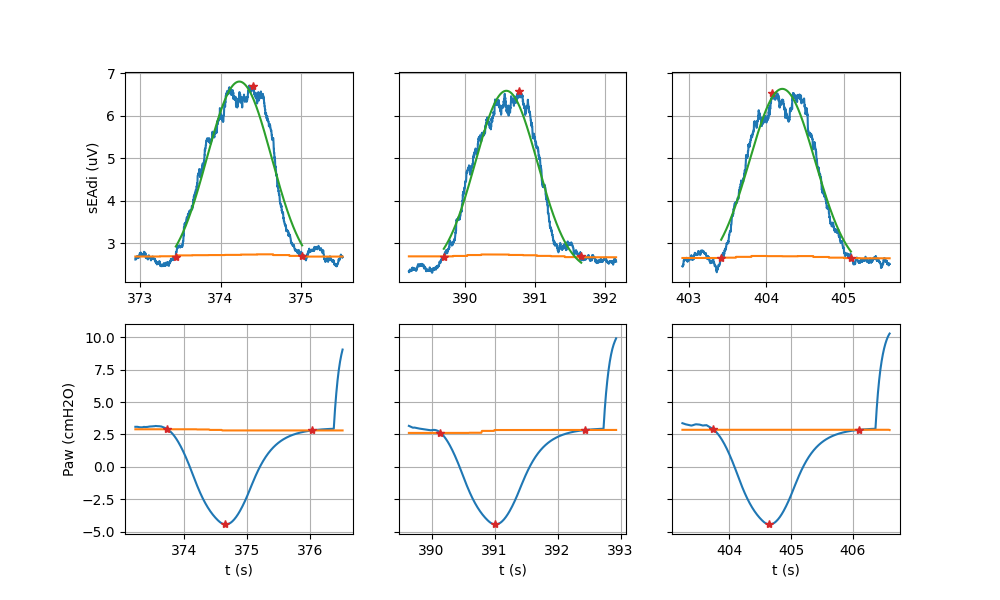

In [ ]:
# Plot the individual peaks bell-fit
n_peaks = len(emg_di.peaks['Pocc'].peak_df['start_idx'].to_numpy())
fig, axis = plt.subplots(nrows=2, ncols=n_peaks, figsize=(10, 6), sharey='row')

axes_emg = axis[0, :]
colors = ['tab:cyan', 'tab:orange', 'tab:red']
emg_di.plot_peaks(axes=axes_emg, peak_set_name='Pocc')
emg_di.plot_markers(axes=axes_emg, peak_set_name='Pocc')
emg_di.plot_curve_fits(axes=axes_emg, peak_set_name='Pocc')
axes_emg[0].set_ylabel('sEAdi (uV)')

axes_vent = axis[1, :]
p_vent.plot_peaks(axes=axes_vent, peak_set_name='Pocc')
p_vent.plot_markers(axes=axes_vent, peak_set_name='Pocc')

for axis in axes_vent:
    axis.set_xlabel('t (s)')

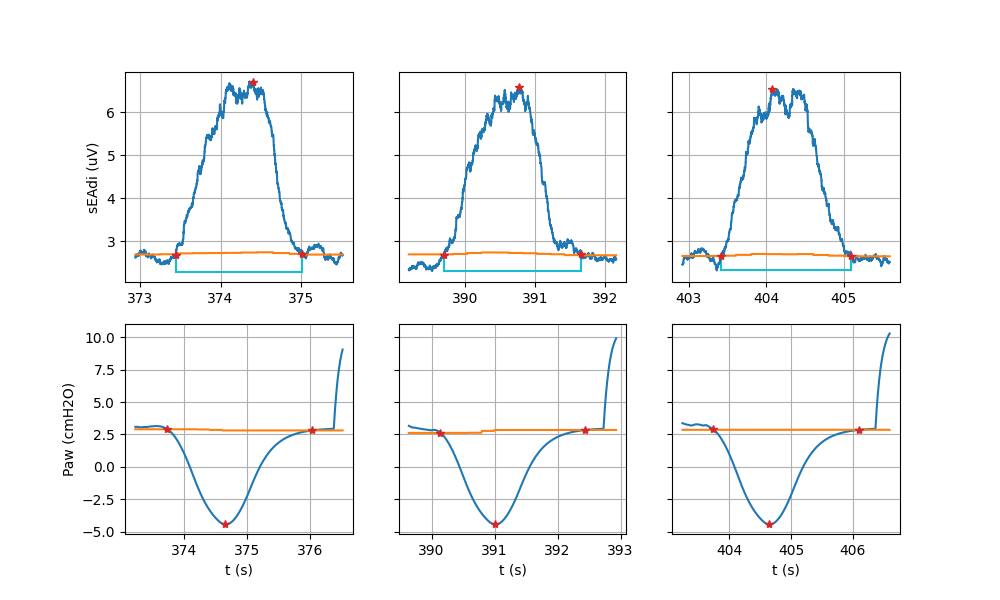

In [ ]:
# Plot the individual peaks area under the baseline
n_peaks = len(emg_di.peaks['Pocc'].peak_df['start_idx'].to_numpy())
fig, axis = plt.subplots(nrows=2, ncols=n_peaks, figsize=(10, 6), sharey='row')

axes_emg = axis[0, :]
emg_di.plot_aub(axes=axes_emg, signal_type='env', peak_set_name='Pocc')
colors = ['tab:cyan', 'tab:orange', 'tab:red']
emg_di.plot_peaks(axes=axes_emg, peak_set_name='Pocc')
emg_di.plot_markers(axes=axes_emg, peak_set_name='Pocc')
axes_emg[0].set_ylabel('sEAdi (uV)')

axes_vent = axis[1, :]
p_vent.plot_peaks(axes=axes_vent, peak_set_name='Pocc')
p_vent.plot_markers(axes=axes_vent, peak_set_name='Pocc')

for axis in axes_vent:
    axis.set_xlabel('t (s)')